In [1]:
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torch.utils.data import DataLoader
from sklearn.preprocessing import MinMaxScaler
from pathlib import Path
from model.dataset import Dataset
from model.losses import QuantileLoss
from model.model import QuantileNet

In [2]:
PATH_DATA = Path.cwd() / 'data' / 'files'

In [3]:
data = pd.read_csv((PATH_DATA / 'data.csv'), index_col='time')

In [4]:
data.head(2)

,u100_mean_36.0-5.45,u100_mean_36.0-5.95,u100_mean_36.0-6.45,u100_mean_36.5-5.45,u100_mean_36.5-5.95,u100_mean_36.5-6.45,u100_mean_37.0-5.45,u100_mean_37.0-5.95,u100_mean_37.0-6.45,v100_mean_36.0-5.45,...,sp_spread_36.0-5.45,sp_spread_36.0-5.95,sp_spread_36.0-6.45,sp_spread_36.5-5.45,sp_spread_36.5-5.95,sp_spread_36.5-6.45,sp_spread_37.0-5.45,sp_spread_37.0-5.95,sp_spread_37.0-6.45,production
time,,,,,,,,,,,,,,,,,,,,,
2015-01-01 00:00:00,0.240008,-1.134381,-1.759686,-0.840131,-2.014142,-2.166547,-2.445111,-3.015729,-2.189557,-3.024733,...,8.433892,8.393884,7.917718,8.122979,7.941735,7.307031,7.844842,7.255090,6.620324,593.580
2015-01-01 03:00:00,0.267507,-0.814769,-1.232799,-1.299937,-2.336314,-2.264842,-2.922008,-3.598949,-2.659495,-3.378693,...,5.420375,6.943202,8.109828,5.365626,7.012294,7.987330,7.272120,7.877955,7.534816,533.846


Convert the dataframe into a pytorch tensor

In [5]:
data_tensor = torch.tensor(data.values, dtype=torch.float32)

Split the data into train, validation and test

In [6]:
n_val = 1000
n_test = 1000
n_train = len(data_tensor) - (n_val + n_test)

data_train =  data_tensor[:n_train, :]
data_val =  data_tensor[n_train:n_train + n_val, :]
data_test =  data_tensor[-n_test:, :]

Scale the variables

In [7]:
scaler = MinMaxScaler()
scaler.fit(data_train)

train_scaled = scaler.transform(data_train)

In [8]:
inputs, target = train_scaled[:, :-1], train_scaled[:, -1:]

In [9]:
quantilenet = QuantileNet()
print(quantilenet)

QuantileNet(
  (layers): Sequential(
    (0): Linear(in_features=126, out_features=50, bias=True)
    (1): ReLU()
    (2): Linear(in_features=50, out_features=20, bias=True)
    (3): ReLU()
    (4): Linear(in_features=20, out_features=2, bias=True)
  )
)


For this example we will use the quantiles 0.05 and 0.95

In [10]:
quantiles = torch.tensor([.05, .95])

In [11]:
optimizer = optim.SGD(quantilenet.parameters(), lr=0.003)

dataset = Dataset(inputs, target)
trainloader = DataLoader(dataset=dataset, batch_size=64)
criterion = QuantileLoss(quantiles)

Train the model

In [12]:
loss_list = []

for epoch in range(1000):

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # inputs and target
        inputs, target = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = quantilenet(inputs)
        loss = criterion(outputs, target)
        
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()

        if i % 1000 == 0:    # print every 1000 mini-batches
            print(i)
            print(f'epoch: {epoch + 1}, batch: {i + 1}, loss: {running_loss}')
            
            loss_list.append(running_loss)
            running_loss = 0.0
            

print('Finished Training')

0
epoch: 1, batch: 1, loss: 0.17383615672588348
0
epoch: 2, batch: 1, loss: 0.03404601290822029
0
epoch: 3, batch: 1, loss: 0.037224531173706055
0
epoch: 4, batch: 1, loss: 0.03987972065806389
0
epoch: 5, batch: 1, loss: 0.03989371284842491
0
epoch: 6, batch: 1, loss: 0.03962491452693939
0
epoch: 7, batch: 1, loss: 0.039341580122709274
0
epoch: 8, batch: 1, loss: 0.039059191942214966
0
epoch: 9, batch: 1, loss: 0.03876858204603195
0
epoch: 10, batch: 1, loss: 0.038495730608701706
0
epoch: 11, batch: 1, loss: 0.038211144506931305
0
epoch: 12, batch: 1, loss: 0.037895239889621735
0
epoch: 13, batch: 1, loss: 0.03761092200875282
0
epoch: 14, batch: 1, loss: 0.037283193320035934
0
epoch: 15, batch: 1, loss: 0.03698143735527992
0
epoch: 16, batch: 1, loss: 0.036658626049757004
0
epoch: 17, batch: 1, loss: 0.03636644780635834
0
epoch: 18, batch: 1, loss: 0.036077987402677536
0
epoch: 19, batch: 1, loss: 0.03569165989756584
0
epoch: 20, batch: 1, loss: 0.035336513072252274
0
epoch: 21, batch:

0
epoch: 165, batch: 1, loss: 0.014126027002930641
0
epoch: 166, batch: 1, loss: 0.014100110158324242
0
epoch: 167, batch: 1, loss: 0.014082303270697594
0
epoch: 168, batch: 1, loss: 0.014081011526286602
0
epoch: 169, batch: 1, loss: 0.014070114120841026
0
epoch: 170, batch: 1, loss: 0.014054984785616398
0
epoch: 171, batch: 1, loss: 0.014046312309801579
0
epoch: 172, batch: 1, loss: 0.014040695503354073
0
epoch: 173, batch: 1, loss: 0.014028482139110565
0
epoch: 174, batch: 1, loss: 0.014023449271917343
0
epoch: 175, batch: 1, loss: 0.014010366052389145
0
epoch: 176, batch: 1, loss: 0.014003333635628223
0
epoch: 177, batch: 1, loss: 0.013992467895150185
0
epoch: 178, batch: 1, loss: 0.01398531161248684
0
epoch: 179, batch: 1, loss: 0.013978538103401661
0
epoch: 180, batch: 1, loss: 0.013965636491775513
0
epoch: 181, batch: 1, loss: 0.013956725597381592
0
epoch: 182, batch: 1, loss: 0.01394440047442913
0
epoch: 183, batch: 1, loss: 0.013932330533862114
0
epoch: 184, batch: 1, loss: 0.0

0
epoch: 327, batch: 1, loss: 0.013919779099524021
0
epoch: 328, batch: 1, loss: 0.013926130719482899
0
epoch: 329, batch: 1, loss: 0.013914855197072029
0
epoch: 330, batch: 1, loss: 0.013916791416704655
0
epoch: 331, batch: 1, loss: 0.013909267261624336
0
epoch: 332, batch: 1, loss: 0.013902967795729637
0
epoch: 333, batch: 1, loss: 0.013911163434386253
0
epoch: 334, batch: 1, loss: 0.013898582197725773
0
epoch: 335, batch: 1, loss: 0.013896582648158073
0
epoch: 336, batch: 1, loss: 0.013868727721273899
0
epoch: 337, batch: 1, loss: 0.013900537975132465
0
epoch: 338, batch: 1, loss: 0.013873394578695297
0
epoch: 339, batch: 1, loss: 0.013914171606302261
0
epoch: 340, batch: 1, loss: 0.013872655108571053
0
epoch: 341, batch: 1, loss: 0.013917457312345505
0
epoch: 342, batch: 1, loss: 0.013880513608455658
0
epoch: 343, batch: 1, loss: 0.013872063718736172
0
epoch: 344, batch: 1, loss: 0.013885150663554668
0
epoch: 345, batch: 1, loss: 0.013920517638325691
0
epoch: 346, batch: 1, loss: 0

0
epoch: 489, batch: 1, loss: 0.013813021592795849
0
epoch: 490, batch: 1, loss: 0.013824977912008762
0
epoch: 491, batch: 1, loss: 0.013792144134640694
0
epoch: 492, batch: 1, loss: 0.013788554817438126
0
epoch: 493, batch: 1, loss: 0.0137909185141325
0
epoch: 494, batch: 1, loss: 0.013777738437056541
0
epoch: 495, batch: 1, loss: 0.013773170299828053
0
epoch: 496, batch: 1, loss: 0.013779284432530403
0
epoch: 497, batch: 1, loss: 0.013773764483630657
0
epoch: 498, batch: 1, loss: 0.013793978840112686
0
epoch: 499, batch: 1, loss: 0.013787688687443733
0
epoch: 500, batch: 1, loss: 0.01376358326524496
0
epoch: 501, batch: 1, loss: 0.013778581283986568
0
epoch: 502, batch: 1, loss: 0.01378510519862175
0
epoch: 503, batch: 1, loss: 0.013779017142951488
0
epoch: 504, batch: 1, loss: 0.013762018643319607
0
epoch: 505, batch: 1, loss: 0.013779780827462673
0
epoch: 506, batch: 1, loss: 0.013780998066067696
0
epoch: 507, batch: 1, loss: 0.013780016452074051
0
epoch: 508, batch: 1, loss: 0.013

0
epoch: 651, batch: 1, loss: 0.013380203396081924
0
epoch: 652, batch: 1, loss: 0.013373673893511295
0
epoch: 653, batch: 1, loss: 0.013376118615269661
0
epoch: 654, batch: 1, loss: 0.013365758582949638
0
epoch: 655, batch: 1, loss: 0.013374061323702335
0
epoch: 656, batch: 1, loss: 0.013365239836275578
0
epoch: 657, batch: 1, loss: 0.013362254947423935
0
epoch: 658, batch: 1, loss: 0.013366267085075378
0
epoch: 659, batch: 1, loss: 0.013348933309316635
0
epoch: 660, batch: 1, loss: 0.013348877429962158
0
epoch: 661, batch: 1, loss: 0.01334172859787941
0
epoch: 662, batch: 1, loss: 0.013337633572518826
0
epoch: 663, batch: 1, loss: 0.01333573181182146
0
epoch: 664, batch: 1, loss: 0.013340670615434647
0
epoch: 665, batch: 1, loss: 0.013334395363926888
0
epoch: 666, batch: 1, loss: 0.01334028597921133
0
epoch: 667, batch: 1, loss: 0.013328569009900093
0
epoch: 668, batch: 1, loss: 0.013324961066246033
0
epoch: 669, batch: 1, loss: 0.013331407681107521
0
epoch: 670, batch: 1, loss: 0.01

0
epoch: 813, batch: 1, loss: 0.012996815145015717
0
epoch: 814, batch: 1, loss: 0.013005336746573448
0
epoch: 815, batch: 1, loss: 0.013006623834371567
0
epoch: 816, batch: 1, loss: 0.013002103194594383
0
epoch: 817, batch: 1, loss: 0.013003225438296795
0
epoch: 818, batch: 1, loss: 0.013000806793570518
0
epoch: 819, batch: 1, loss: 0.012996400706470013
0
epoch: 820, batch: 1, loss: 0.013024616986513138
0
epoch: 821, batch: 1, loss: 0.012987041845917702
0
epoch: 822, batch: 1, loss: 0.012991240248084068
0
epoch: 823, batch: 1, loss: 0.01302148588001728
0
epoch: 824, batch: 1, loss: 0.012983587570488453
0
epoch: 825, batch: 1, loss: 0.012998733669519424
0
epoch: 826, batch: 1, loss: 0.013012038543820381
0
epoch: 827, batch: 1, loss: 0.012979831546545029
0
epoch: 828, batch: 1, loss: 0.012995714321732521
0
epoch: 829, batch: 1, loss: 0.013012384995818138
0
epoch: 830, batch: 1, loss: 0.012996751815080643
0
epoch: 831, batch: 1, loss: 0.01299348659813404
0
epoch: 832, batch: 1, loss: 0.0

0
epoch: 975, batch: 1, loss: 0.01298554241657257
0
epoch: 976, batch: 1, loss: 0.01298114936798811
0
epoch: 977, batch: 1, loss: 0.012969378381967545
0
epoch: 978, batch: 1, loss: 0.012964006513357162
0
epoch: 979, batch: 1, loss: 0.012972250580787659
0
epoch: 980, batch: 1, loss: 0.01296565867960453
0
epoch: 981, batch: 1, loss: 0.012956704944372177
0
epoch: 982, batch: 1, loss: 0.012958788312971592
0
epoch: 983, batch: 1, loss: 0.01297300960868597
0
epoch: 984, batch: 1, loss: 0.012962638400495052
0
epoch: 985, batch: 1, loss: 0.012962411157786846
0
epoch: 986, batch: 1, loss: 0.012958565726876259
0
epoch: 987, batch: 1, loss: 0.012958577834069729
0
epoch: 988, batch: 1, loss: 0.012944058515131474
0
epoch: 989, batch: 1, loss: 0.01295411679893732
0
epoch: 990, batch: 1, loss: 0.01295104157179594
0
epoch: 991, batch: 1, loss: 0.01296401396393776
0
epoch: 992, batch: 1, loss: 0.012952457182109356
0
epoch: 993, batch: 1, loss: 0.012938089668750763
0
epoch: 994, batch: 1, loss: 0.012940

Loss results

In [13]:
import matplotlib.pyplot as plt

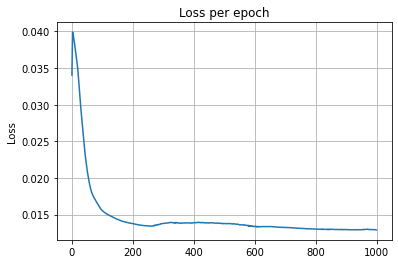

In [14]:
loss_ss = pd.Series(loss_list[1:])
loss_ss.plot()
plt.ylabel('Loss')
plt.title('Loss per epoch')
plt.grid()

Predictions validation set

In [18]:
val_scaled = scaler.transform(data_val)
inputs, target = val_scaled[:, :-1], val_scaled[:, -1:]

inputs = torch.tensor(inputs, dtype=torch.float32)
target = torch.tensor(target, dtype=torch.float32)

In [19]:
y_pred = quantilenet(inputs)
y_test = pd.Series(target.squeeze().tolist())
y_preds = pd.DataFrame(y_pred.tolist())

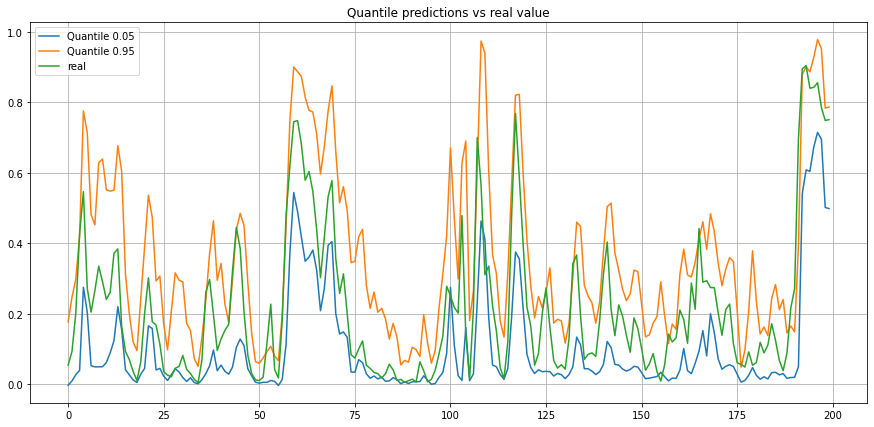

In [22]:
fig, ax = plt.subplots(figsize=(15, 7))
y_preds[:200].plot(ax=ax)
y_test[:200].plot(ax=ax)
ax.legend(['Quantile 0.05', 'Quantile 0.95', 'real'])
ax.set_title('Quantile predictions vs real value')
plt.grid()

In [24]:
out_low = (y_test < y_preds[0]).sum() / len(y_test)
out_high = (y_test > y_preds[1]).sum() / len(y_test)

In [25]:
print(f'pct of time real value is below the predicted 0.05 quantile: {out_low}')
print(f'pct of time real value is below the predicted 0.95 quantile: {out_high}')

pct of time real value is below the predicted 0.05 quantile: 0.058
pct of time real value is below the predicted 0.95 quantile: 0.061
